In [1]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

from sequential_ft_transformer.fttransformer import ft_transformer
from sequential_ft_transformer.preprocessing import sq_df_to_dataset, download_data
from sequential_ft_transformer.plotting import get_model_importances, plot_training_hist


2024-01-01 17:06:58.985770: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-01 17:06:58.988231: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-01 17:06:59.026462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 17:06:59.026648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 17:06:59.028588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Download Data

In [2]:
data_folder = "../data/"
seq_length = 1

In [3]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

download_data(train_data_url, data_folder, "adult_train.csv")
download_data(test_data_url, data_folder, "adult_test.csv")

train_data = pd.read_csv(os.path.join(data_folder, "adult_train.csv"), header=None, names=CSV_HEADER)
test_data = pd.read_csv(os.path.join(data_folder, "adult_test.csv"), header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

adult_train.csv already exists in ../data/
adult_test.csv already exists in ../data/
Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [4]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess

In [5]:
# Column information
NUMERIC_FEATURES = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
NUMERIC_FEATURES = sorted(NUMERIC_FEATURES)
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country']
CATEGORICAL_FEATURES = sorted(CATEGORICAL_FEATURES)

FEATURES = sorted(list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES))
LABEL = 'income_bracket'

In [6]:
# encoding as binary target
train_data[LABEL] = train_data[LABEL].apply(lambda x: int(x == ' >50K')) 
test_data[LABEL] = test_data[LABEL].apply(lambda x: int(x == ' >50K.'))

In [7]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [8]:
train_input = train_data[FEATURES]
train_labels = train_data[LABEL]

test_input = test_data[FEATURES]
test_labels = test_data[LABEL]

## Get Lookup Tables for Each Categorical Column

In [9]:
cat_lookups = dict()
feature_unique_counts = dict()
num_oov_indices = 1
for cat in CATEGORICAL_FEATURES:
    unique_values = list(np.unique(train_input[cat]).astype(str))
    feature_unique_counts[cat] = len(unique_values) + num_oov_indices
    lookup = tf.keras.layers.StringLookup(vocabulary=unique_values, num_oov_indices=num_oov_indices)
    cat_lookups[cat] = lookup

2024-01-01 17:07:01.443700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-01 17:07:01.444060: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Convert Each Categorical String to an ID

In [10]:
for cat in CATEGORICAL_FEATURES:
    train_input[cat] = cat_lookups[cat](train_input[cat])
    test_input[cat] = cat_lookups[cat](test_input[cat])

/tmp/ipykernel_708351/1451819549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_input[cat] = cat_lookups[cat](train_input[cat])
/tmp/ipykernel_708351/1451819549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_input[cat] = cat_lookups[cat](test_input[cat])


In [11]:
train_input.loc[:, CATEGORICAL_FEATURES] = train_input[CATEGORICAL_FEATURES].astype(int)
test_input.loc[:, CATEGORICAL_FEATURES] = test_input[CATEGORICAL_FEATURES].astype(int)

train_input.loc[:, NUMERIC_FEATURES] = train_input[NUMERIC_FEATURES].astype(float)
test_input.loc[:, NUMERIC_FEATURES] = test_input[NUMERIC_FEATURES].astype(float)

In [12]:
train_labels = train_labels.to_frame(name=LABEL)
test_labels = test_labels.to_frame(name=LABEL)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(train_input, train_labels, test_size=0.2)

## Create TF Datasets

In [14]:
batch_size = 1000
train_dataset = sq_df_to_dataset(
    x_train, 
    seq_length, 
    target_df=y_train, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    batch_size=batch_size
)
val_dataset = sq_df_to_dataset(
    x_val, 
    seq_length, 
    target_df=y_val, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, # No shuffle
    batch_size=batch_size
)  
test_dataset = sq_df_to_dataset(
    test_input, 
    seq_length, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, 
    batch_size=batch_size) # No target, no shuffle

## Create bins for PLE

## Target-Aware Bins

In [15]:
from sklearn.tree import DecisionTreeClassifier

N_BINS = 10

t_bins_dict = dict()
for feature in NUMERIC_FEATURES:
    data = x_train[feature].values.reshape(-1, 1)
    y = y_train[LABEL].values

    dt = DecisionTreeClassifier(max_leaf_nodes=N_BINS)
    dt.fit(data, y)
    bins = np.unique(dt.tree_.threshold).astype("float32")
    t_bins_dict[feature] = bins

In [16]:
t_bins_dict

{'age': array([-2. , 24.5, 27.5, 29.5, 33.5, 35.5, 43.5, 54.5, 61.5, 68.5],
       dtype=float32),
 'capital_gain': array([-2.0000e+00,  5.7000e+01,  3.0400e+03,  3.1200e+03,  4.2435e+03,
         4.4010e+03,  5.1190e+03,  5.3165e+03,  6.4575e+03,  7.0735e+03],
       dtype=float32),
 'capital_loss': array([-2.0000e+00,  1.5515e+03,  1.5685e+03,  1.8205e+03,  1.8620e+03,
         1.8815e+03,  1.9785e+03,  2.1685e+03,  2.3645e+03,  3.3435e+03],
       dtype=float32),
 'education_num': array([-2. ,  2.5,  7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5],
       dtype=float32),
 'hours_per_week': array([-2. , 34.5, 39.5, 41.5, 43.5, 45.5, 49.5, 61.5, 79. , 80.5],
       dtype=float32)}

## Quantile Bins

In [17]:
N_BINS = 10

interval = 1 / N_BINS
intervals = np.arange(0.0, 1 + interval, interval)

q_bins_dict = dict()
for feature in NUMERIC_FEATURES:
    data = x_train[feature]

    bins = np.quantile(np.unique(data.values), intervals)
    q_bins_dict[feature] = bins

In [18]:
q_bins_dict

{'age': array([17., 24., 31., 38., 45., 52., 59., 66., 73., 80., 90.]),
 'capital_gain': array([    0. ,  1419.5,  2079.2,  2418.9,  2963.4,  3572.5,  4657.4,
         6059.4,  7812.8, 14546.8, 99999. ]),
 'capital_loss': array([   0.,  974., 1504., 1628., 1735., 1876., 2042., 2201., 2339.,
        2547., 4356.]),
 'education_num': array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 'hours_per_week': array([ 1. , 10.1, 19.2, 28.3, 37.4, 46.5, 55.6, 64.7, 75.8, 88.9, 99. ])}

In [31]:
EXPLANATIONS = True
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 10

## Target-Aware PLE Transformer

In [32]:
# Pass the encoder to the model
model = ft_transformer(
    out_dim=1,
    out_activation='sigmoid',
    numerical_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    feature_unique_counts=feature_unique_counts,
    seq_length=seq_length,
    embedding_dim=16,
    depth=4,
    heads=8,
    numerical_embedding_type='ple',
    bins_dict=t_bins_dict,
    explainable=EXPLANATIONS
)

optimizer = tf.keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss_dict = {"output": tf.keras.losses.BinaryCrossentropy()}
metrics_dict = {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR')]}
if EXPLANATIONS:
    loss_dict.update({"importances": None})
    metrics_dict.update({"importances": None})

model.compile(
    optimizer = optimizer,
    loss = loss_dict,
    metrics= metrics_dict,
)

early = EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

In [33]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/10


27/27 [==============================] - 20s 431ms/step - loss: 0.4533 - output_loss: 0.4533 - output_PR AUC: 0.5130 - val_loss: 0.3953 - val_output_loss: 0.3953 - val_output_PR AUC: 0.7181
Epoch 2/10
27/27 [==============================] - 10s 364ms/step - loss: 0.3610 - output_loss: 0.3610 - output_PR AUC: 0.6985 - val_loss: 0.3429 - val_output_loss: 0.3429 - val_output_PR AUC: 0.7514
Epoch 3/10
27/27 [==============================] - 10s 363ms/step - loss: 0.3418 - output_loss: 0.3418 - output_PR AUC: 0.7306 - val_loss: 0.3359 - val_output_loss: 0.3359 - val_output_PR AUC: 0.7610
Epoch 4/10
27/27 [==============================] - 10s 368ms/step - loss: 0.3296 - output_loss: 0.3296 - output_PR AUC: 0.7507 - val_loss: 0.3229 - val_output_loss: 0.3229 - val_output_PR AUC: 0.7765
Epoch 5/10
27/27 [==============================] - 10s 379ms/step - loss: 0.3219 - output_loss: 0.3219 - output_PR AUC: 0.7646 - val_loss: 0.3155 - val_output_loss: 0.3155 - val_output_PR AUC: 0.7840
Epoch 

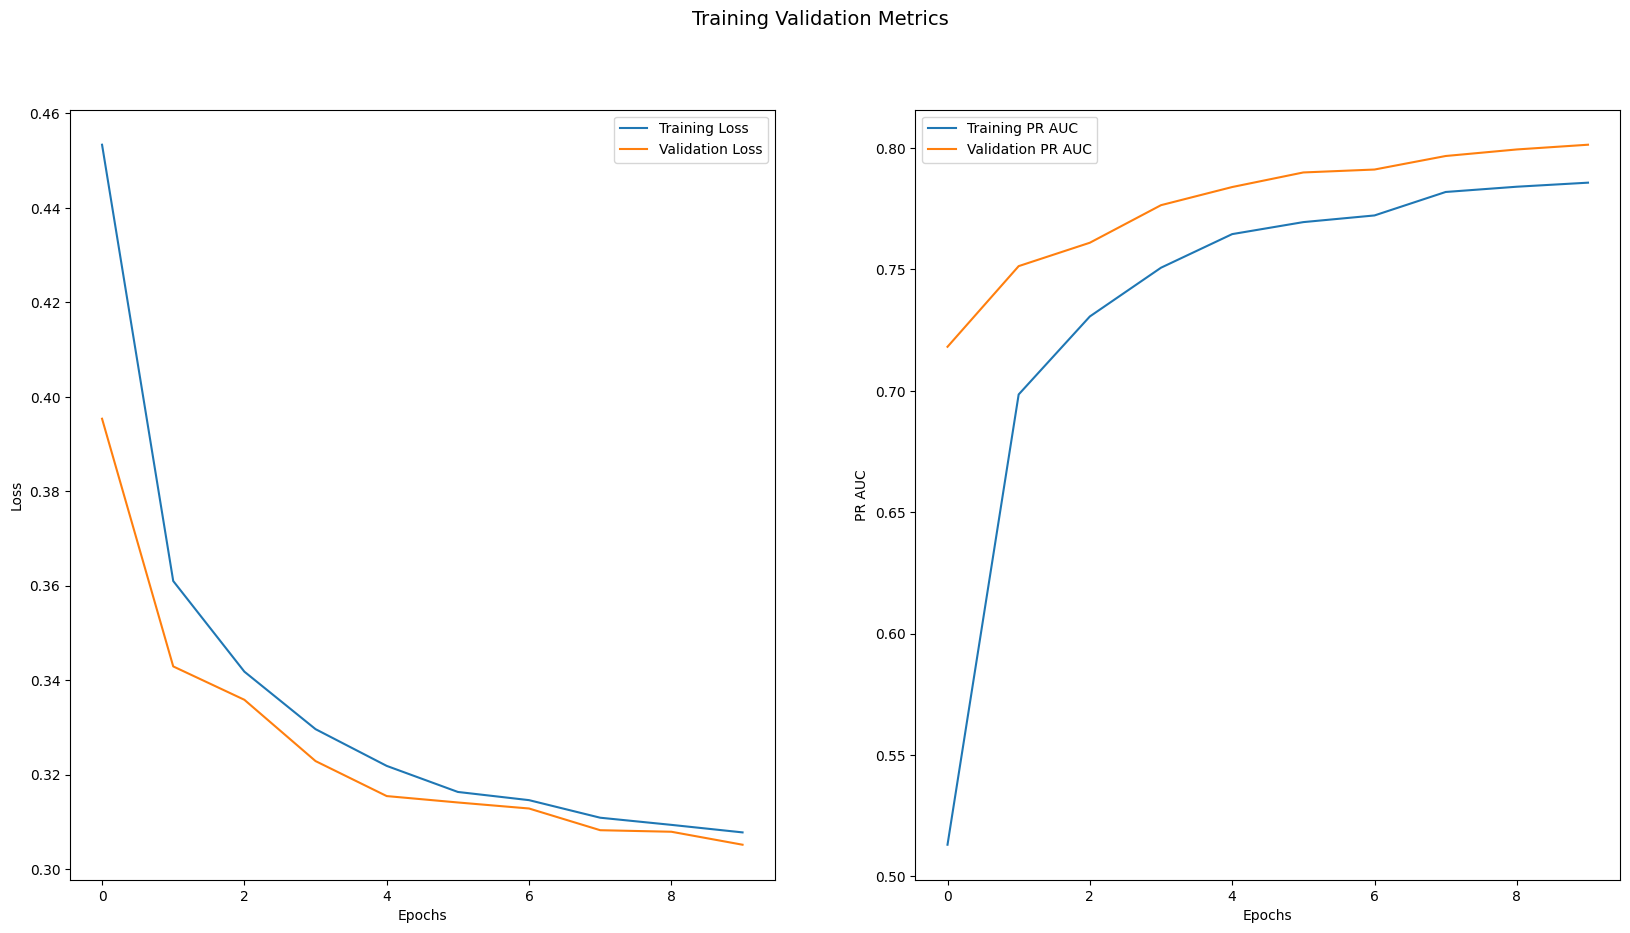

In [34]:
hist_plot = plot_training_hist(hist, EXPLANATIONS)

In [35]:
preds = model.predict(test_dataset)
print("FT-Transformer with Linear Numerical Embedding")
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], preds['output'].ravel()), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], preds['output'].ravel()), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], preds['output'].ravel()>0.5), 4))

# Reported accuracy - 0.858

17/17 [==============================] - 3s 130ms/step
FT-Transformer with Linear Numerical Embedding
Test ROC AUC: 0.9101
Test PR AUC: 0.7812
Test Accuracy: 0.8574


## Explainability

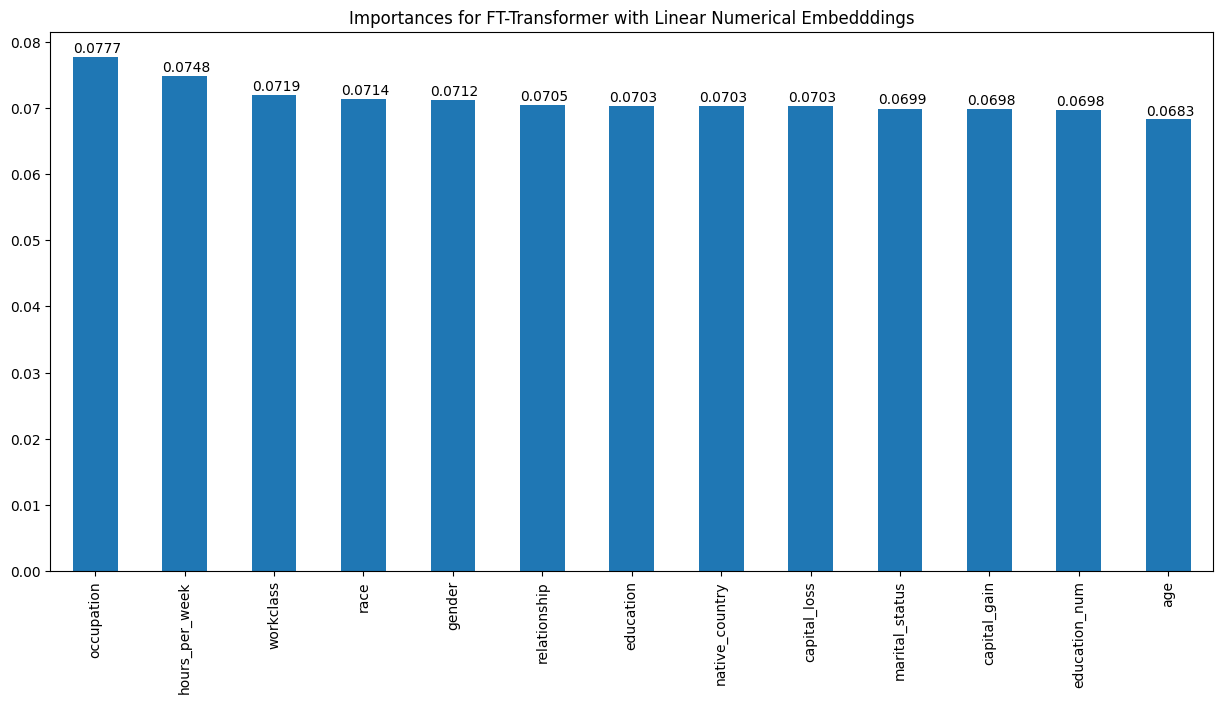

In [36]:
if 'importances' in preds.keys():
    linear_importances = preds['importances']
    linear_importances_df = pd.DataFrame(linear_importances[:, :-1], columns = FEATURES)
    linear_total_importances = get_model_importances(
        linear_importances_df, title="Importances for FT-Transformer with Linear Numerical Embedddings"
    )

## Quantile PLE Transformer

In [37]:
# Pass the encoder to the model
model = ft_transformer(
    out_dim=1,
    out_activation='sigmoid',
    numerical_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    feature_unique_counts=feature_unique_counts,
    seq_length=seq_length,
    embedding_dim=16,
    depth=4,
    heads=8,
    numerical_embedding_type='ple',
    bins_dict=q_bins_dict,
    explainable=EXPLANATIONS
)

optimizer = tf.keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss_dict = {"output": tf.keras.losses.BinaryCrossentropy()}
metrics_dict = {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR')]}
if EXPLANATIONS:
    loss_dict.update({"importances": None})
    metrics_dict.update({"importances": None})

model.compile(
    optimizer=optimizer,
    loss=loss_dict,
    metrics=metrics_dict,
)

early = EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

In [38]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/10


27/27 [==============================] - 21s 438ms/step - loss: 0.4902 - output_loss: 0.4902 - output_PR AUC: 0.4231 - val_loss: 0.4190 - val_output_loss: 0.4190 - val_output_PR AUC: 0.5936
Epoch 2/10
27/27 [==============================] - 10s 372ms/step - loss: 0.3919 - output_loss: 0.3919 - output_PR AUC: 0.6289 - val_loss: 0.3667 - val_output_loss: 0.3667 - val_output_PR AUC: 0.6668
Epoch 3/10
27/27 [==============================] - 10s 367ms/step - loss: 0.3577 - output_loss: 0.3577 - output_PR AUC: 0.6882 - val_loss: 0.3460 - val_output_loss: 0.3460 - val_output_PR AUC: 0.7358
Epoch 4/10
27/27 [==============================] - 10s 368ms/step - loss: 0.3421 - output_loss: 0.3421 - output_PR AUC: 0.7212 - val_loss: 0.3345 - val_output_loss: 0.3345 - val_output_PR AUC: 0.7521
Epoch 5/10
27/27 [==============================] - 10s 369ms/step - loss: 0.3286 - output_loss: 0.3286 - output_PR AUC: 0.7471 - val_loss: 0.3242 - val_output_loss: 0.3242 - val_output_PR AUC: 0.7665
Epoch 

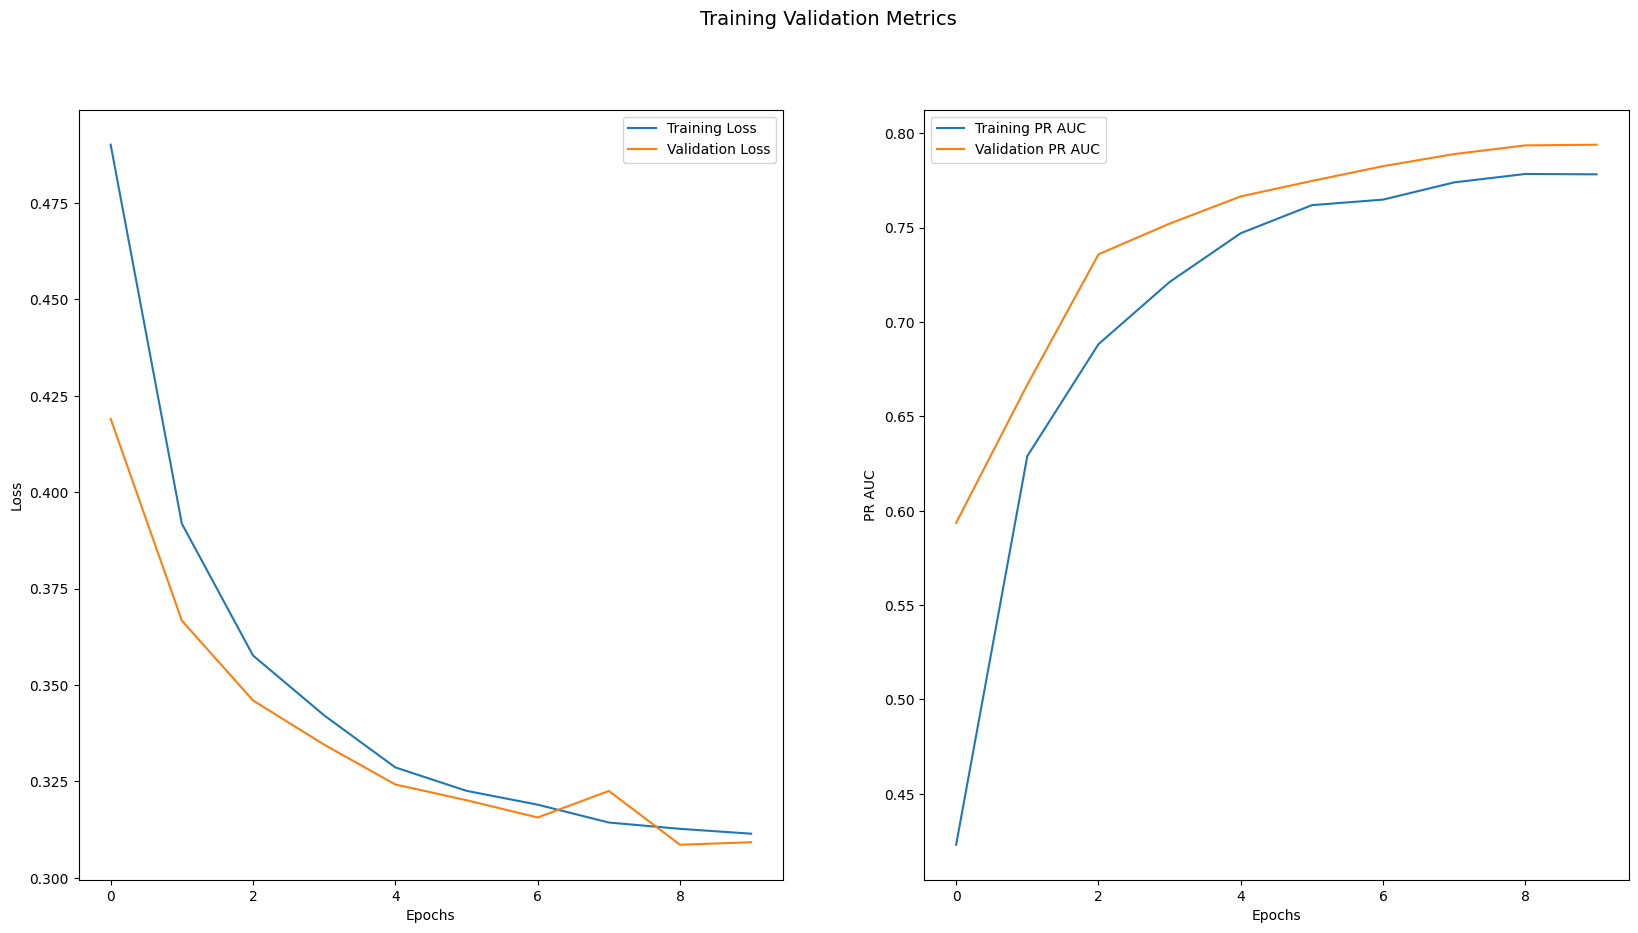

In [39]:
hist_plot = plot_training_hist(hist, EXPLANATIONS)

In [40]:
preds = model.predict(test_dataset)
print("FT-Transformer with Linear Numerical Embedding")
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], preds['output'].ravel()), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], preds['output'].ravel()), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], preds['output'].ravel()>0.5), 4))

# Reported accuracy - 0.858

17/17 [==============================] - 4s 126ms/step
FT-Transformer with Linear Numerical Embedding
Test ROC AUC: 0.9091
Test PR AUC: 0.7768
Test Accuracy: 0.8555


## Explainability

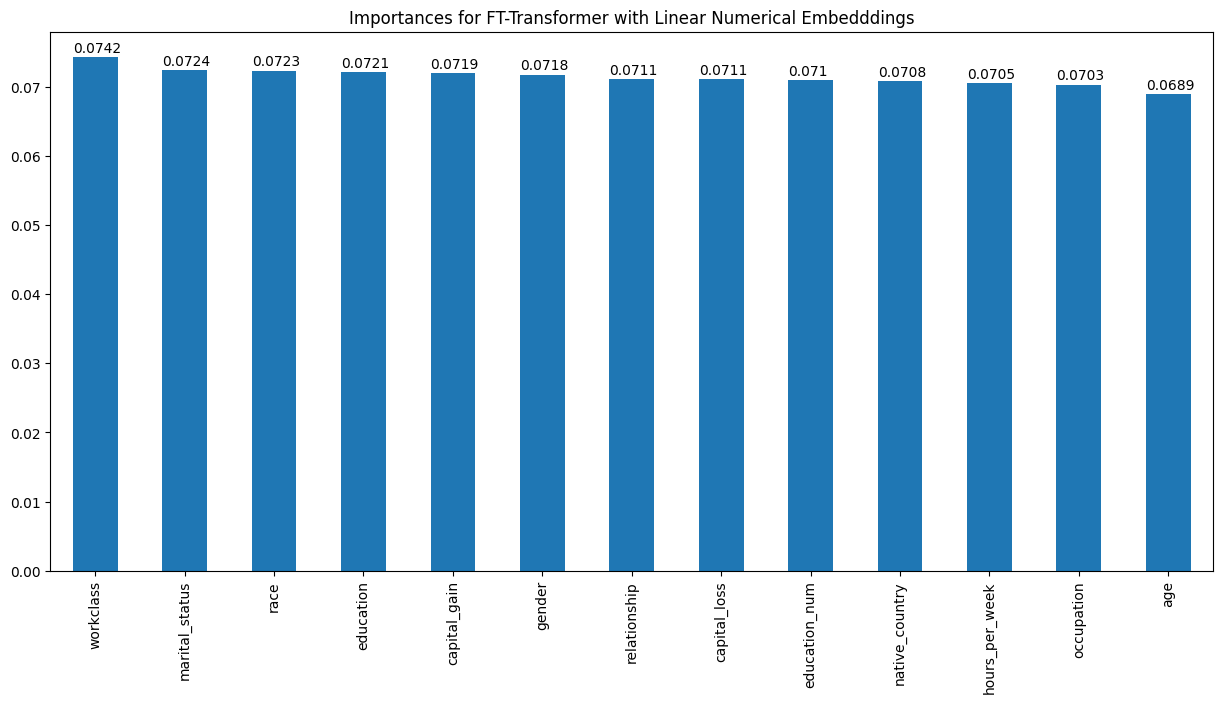

In [41]:
if 'importances' in preds.keys():
    linear_importances = preds['importances']
    linear_importances_df = pd.DataFrame(linear_importances[:, :-1], columns = FEATURES)
    linear_total_importances = get_model_importances(
        linear_importances_df, title="Importances for FT-Transformer with Linear Numerical Embedddings"
    )